In [1]:
import pandas as pd
import numpy as np

import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler        #평균 0, 표준편차 1로 데이터 스케일링 도구

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,     #정확도
    # precision_score,    #정밀도
    # recall_score,       #재현율
    # f1_score,           #f1 스코어,
    classification_report,
    confusion_matrix,
    roc_auc_score,                  #ROC-AUC 점수
    roc_curve,                      #ROC 곡선 좌표 계산
    ConfusionMatrixDisplay  #혼동 행렬 시각화
)

import torch                                            #Tensor 연산 및 핵심 기능
import torch.nn as nn                                   #신경망 레이어 구성 및 모델 구성 모듈
import torch.nn.functional as F                         #활성화함수/손실함수 등 함수
import torch.optim as optim                             #옵티마이저(최적화 알고리즘)

In [ ]:
df = pd.read_csv('./data/reviews_joined_all_matched.csv')   # steam_reviews_last365d (1년치 데이터)
df.head(3)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_17692\917631865.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/reviews_joined_all_matched.csv')


,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,...,comment_count,steam_purchase,received_for_free,written_during_early_access,developer_response,timestamp_dev_responded,primarily_steam_deck,appid_1,game_name,genre
0,2139460,199685023,76561198220582271,23,1,15240.0,0.0,15240,NaN,1.748034e+09,...,1,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
1,2139460,199684668,76561198401253542,0,1,6249.0,0.0,834,NaN,1.755746e+09,...,0,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
2,2139460,199683985,76561199435851437,0,1,20522.0,0.0,12327,NaN,1.755124e+09,...,0,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."


In [3]:
df.shape

(1030656, 28)

### EDA(Exploratory Data Analysis, 탐색적 데이터 분석)

In [4]:
df.describe()   #수치형 변수 확인

# df.info()
df.isnull().sum()   #결측값 확인

appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                    11
playtime_last_two_weeks             11
playtime_at_review                   0
deck_playtime_at_review        1011112
last_played                         11
language                             0
review                            3568
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             1027150
timestamp_dev_responded        1027150
primarily_steam_deck                 0
appid_1                  

In [5]:
#결측값 처리
df['playtime_forever'].fillna(0,inplace=True)
df['playtime_last_two_weeks'].fillna(0,inplace=True)
df['deck_playtime_at_review'].fillna(0,inplace=True)
df['last_played'].fillna(0,inplace=True)
df['review'].fillna('N',inplace=True)
df['developer_response'].fillna('N',inplace=True)
df['timestamp_dev_responded'].fillna(0,inplace=True)

df.isnull().sum()

appid                          0
recommendationid               0
steamid                        0
num_games_owned                0
num_reviews_author             0
playtime_forever               0
playtime_last_two_weeks        0
playtime_at_review             0
deck_playtime_at_review        0
last_played                    0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
developer_response             0
timestamp_dev_responded        0
primarily_steam_deck           0
appid_1                        0
game_name                      0
genre                          0
dtype: int64

In [6]:
df.columns  #칼럼명 확인

Index(['appid', 'recommendationid', 'steamid', 'num_games_owned',
       'num_reviews_author', 'playtime_forever', 'playtime_last_two_weeks',
       'playtime_at_review', 'deck_playtime_at_review', 'last_played',
       'language', 'review', 'timestamp_created', 'timestamp_updated',
       'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'comment_count', 'steam_purchase', 'received_for_free',
       'written_during_early_access', 'developer_response',
       'timestamp_dev_responded', 'primarily_steam_deck', 'appid_1',
       'game_name', 'genre'],
      dtype='object')

### 데이터 전처리

#### 텍스트 기반 코드 ('review' 칼럼)

In [7]:
# 1) 언어별 키워드 사전
# - phrases: 문장/구문(부분일치 OK)
# - words: 단어성 키워드(라틴권은 단어경계 \b 적용)
# - neg: 부정 구문(걸리면 good=0으로 처리)
# - boundary: words에 \b를 붙일지 여부 (중국어/일본어/태국어/한국어는 보통 False)
LEXICON = {
    # English
    "english": {
        "phrases": [
            r"highly recommend(?:ed)?",
            r"definitely recommend",
            r"worth (?:buying|it|the money|the time)",
            r"great game",
            r"amazing game",
            r"awesome game",
            r"best game(?:s)?",
        ],
        "words": [
            r"awesome", r"amazing", r"great", r"excellent", r"fantastic", r"incredible",
            r"masterpiece", r"perfect", r"love", r"fun", r"enjoy", r"recommend", r"worth",
        ],
        "neg": [
            r"not\s+good", r"not\s+great", r"not\s+worth",
            r"(?:do\s*not|don't|dont)\s+recommend",
            r"(?:do\s*not|don't|dont)\s+buy",
            r"can't\s+recommend|cant\s+recommend",
            r"avoid\b", r"refund\b",
        ],
        "boundary": True,
    },

    # Spanish (Spain) + LatAm는 같이 처리
    "spanish": {
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },
    "latam": {  # 라틴아메리카 스페인어
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },

    # Portuguese (PT / BR)
    "portuguese": {
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },
    "brazilian": {  # 브라질 포르투갈어
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },

    # German
    "german": {
        "phrases": [r"sehr gut", r"klare(?:s)? empfehlung", r"lohnt sich", r"absolut empfehl"],
        "words": [r"genial", r"toll", r"super", r"großartig", r"exzellent", r"empfehle", r"empfehlenswert"],
        "neg": [r"nicht\s+empfehl", r"lohnt\s+sich\s+nicht", r"nicht\s+gut", r"kau(?:f|ft)\s+nicht", r"kein\s+kauf"],
        "boundary": True,
    },

    # French
    "french": {
        "phrases": [r"je recommande", r"vaut le coup", r"tr[eè]s bon", r"excellent jeu"],
        "words": [r"g[eé]nial", r"excellent", r"super", r"incroyable", r"parfait", r"recommande"],
        "neg": [r"je\s+ne\s+recommande\s+pas", r"ne\s+vaut\s+pas\s+le\s+coup", r"pas\s+bon", r"n['’]achetez\s+pas", r"n['’]ach[eè]te\s+pas"],
        "boundary": True,
    },

    # Italian
    "italian": {
        "phrases": [r"lo consiglio", r"vale la pena", r"molto bello", r"gioco (?:molto )?bello"],
        "words": [r"fantastico", r"ottimo", r"eccellente", r"stupendo", r"divertente", r"consiglio", r"consigliare"],
        "neg": [r"non\s+lo\s+consiglio", r"non\s+vale\s+la\s+pena", r"non\s+[eè]\s+bello", r"non\s+compr(?:are|atelo)"],
        "boundary": True,
    },

    # Dutch
    "dutch": {
        "phrases": [r"zeker aanraden", r"de moeite waard", r"heel goed", r"geweldig spel"],
        "words": [r"geweldig", r"fantastisch", r"super", r"leuk", r"aanraden", r"aanbevelen", r"waarde"],
        "neg": [r"niet\s+aanrad", r"niet\s+de\s+moeite\s+waard", r"niet\s+goed", r"koop\s+niet"],
        "boundary": True,
    },

    # Swedish / Norwegian / Danish / Finnish
    "swedish": {
        "phrases": [r"rekommenderar", r"värt det", r"jättebra", r"riktigt bra"],
        "words": [r"fantastisk", r"grym", r"suverän", r"toppen", r"kul", r"rekommendera", r"värd"],
        "neg": [r"rekommenderar\s+inte", r"inte\s+värt", r"inte\s+bra", r"köp\s+inte"],
        "boundary": True,
    },
    "norwegian": {
        "phrases": [r"anbefaler", r"verdt det", r"kjempebra", r"veldig bra"],
        "words": [r"fantastisk", r"råbra", r"suveren", r"gøy", r"anbefale", r"verdt"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+verdt", r"ikke\s+bra", r"ikke\s+kjøp"],
        "boundary": True,
    },
    "danish": {
        "phrases": [r"anbefaler", r"v[æa]rd at", r"mega god", r"rigtig god"],
        "words": [r"fantastisk", r"fremragende", r"super", r"sjov", r"anbefale", r"v[æa]rd"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+v[æa]rd", r"ikke\s+god", r"k[oø]b\s+ikke"],
        "boundary": True,
    },
    "finnish": {
        "phrases": [r"suosittelen", r"todella hyv[äa]", r"sen arvoinen", r"hyv[äa] peli"],
        "words": [r"loistava", r"mahtava", r"erinomainen", r"hauska", r"suositella", r"arvoinen"],
        "neg": [r"en\s+suosittele", r"ei\s+kannata", r"ei\s+hyv[äa]", r"älä\s+osta"],
        "boundary": True,
    },

    # Polish / Czech / Romanian / Hungarian / Bulgarian / Greek / Ukrainian / Russian / Turkish
    "polish": {
        "phrases": [r"polecam", r"warto", r"świetna gra", r"bardzo dobra"],
        "words": [r"świetn[aey]", r"super", r"rewelacyjna", r"doskonała", r"polecić", r"warto"],
        "neg": [r"nie\s+polecam", r"nie\s+warto", r"nie\s+jest\s+dobr", r"nie\s+kupuj"],
        "boundary": True,
    },
    "czech": {
        "phrases": [r"doporu[čc]uji", r"stoj[ií]\s+za\s+to", r"skv[ěe]l[aá]", r"v[ýy]born[aá]"],
        "words": [r"super", r"skv[ěe]l", r"v[ýy]born", r"bav[ií]", r"doporu[čc]it"],
        "neg": [r"nedoporu[čc]uji", r"nestoj[ií]\s+za\s+to", r"nen[ií]\s+dobr", r"nekupuj"],
        "boundary": True,
    },
    "romanian": {
        "phrases": [r"recomand", r"merit[ăa]", r"foarte bun", r"joc (?:foarte )?bun"],
        "words": [r"excelent", r"minunat", r"super", r"recomanda", r"merit"],
        "neg": [r"nu\s+recomand", r"nu\s+merit[ăa]", r"nu\s+e\s+bun", r"nu\s+cump[ăa]ra"],
        "boundary": True,
    },
    "hungarian": {
        "phrases": [r"aj[aá]nlom", r"meg[eé]ri", r"nagyon j[oó]", r"szuper j[aá]t[eé]k"],
        "words": [r"szuper", r"fantasztikus", r"kiv[aá]l[oó]", r"nagyon", r"aj[aá]nlani", r"meg[eé]r"],
        "neg": [r"nem\s+aj[aá]nlom", r"nem\s+[eé]ri\s+meg", r"nem\s+j[oó]", r"ne\s+vedd\s+meg"],
        "boundary": True,
    },
    "bulgarian": {
        "phrases": [r"препоръч", r"много добра", r"страхотна", r"заслужава си"],
        "words": [r"страхот", r"отлич", r"супер", r"препоръч", r"шедьовър"],
        "neg": [r"не\s+препоръч", r"не\s+си\s+струва", r"не\s+е\s+доб", r"не\s+купувай"],
        "boundary": False,  # кир릴은 \b가 애매해서 단순부분일치로
    },
    "greek": {
        "phrases": [r"το\s+προτείν", r"αξίζει", r"πολύ\s+καλ", r"εξαιρετικ"],
        "words": [r"τέλει", r"φοβε", r"εξαιρετικ", r"καταπληκτικ", r"προτείν", r"αξίζ"],
        "neg": [r"δεν\s+προτείν", r"δεν\s+αξίζ", r"δεν\s+είναι\s+καλ", r"μην\s+αγοράσ"],
        "boundary": False,
    },
    "ukrainian": {
        "phrases": [r"рекоменд", r"дуже\s+хорош", r"варто", r"чудов"],
        "words": [r"відмін", r"класн", r"шедевр", r"рекоменд", r"варто"],
        "neg": [r"не\s+рекоменд", r"не\s+варто", r"не\s+хорош", r"не\s+купуй"],
        "boundary": False,
    },
    "russian": {
        "phrases": [r"рекоменд", r"очень\s+хорош", r"стоит", r"шедевр"],
        "words": [r"отлич", r"классн", r"супер", r"шедевр", r"рекоменд", r"стоит"],
        "neg": [r"не\s+рекоменд", r"не\s+стоит", r"плох", r"не\s+покупай", r"не\s+берите"],
        "boundary": False,
    },
    "turkish": {
        "phrases": [r"kesinlikle tavsiye", r"tavsiye ederim", r"çok iyi", r"mükemmel", r"harika"],
        "words": [r"güzel", r"mükemmel", r"harika", r"şahane", r"tavsiye", r"değer"],
        "neg": [r"tavsiye etmem", r"tavsiye etmiyorum", r"iyi değil", r"alma", r"almayın", r"değmez"],
        "boundary": True,
    },

    # Korean / Japanese / Chinese / Arabic / Thai / Vietnamese / Indonesian
    "koreana": {
        "phrases": [r"강추", r"완전 추천", r"강력 추천", r"갓겜", r"명작", r"존잼", r"개꿀잼", r"재밌", r"재미있"],
        "words": [r"추천", r"최고", r"꿀잼", r"재미", r"좋다", r"훌륭", r"완벽", r"감동"],
        "neg": [r"비추", r"추천\s*안", r"추천\s*하지", r"재미없", r"별로", r"최악", r"사지\s*마", r"사지마", r"환불"],
        "boundary": False,
    },
    "japanese": {
        "phrases": [r"おすすめ", r"オススメ", r"最高", r"神ゲー", r"買う価値", r"面白い", r"楽しい"],
        "words": [r"おすすめ", r"最高", r"神", r"面白", r"楽しい", r"良い", r"素晴らしい"],
        "neg": [r"おすすめしない", r"買わない方が", r"つまらない", r"面白くない", r"最悪", r"返品"],
        "boundary": False,
    },
    "schinese": {
        "phrases": [r"强烈推荐", r"非常推荐", r"值得买", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推荐", r"值得", r"好玩", r"很好", r"优秀", r"完美", r"喜欢"],
        "neg": [r"不推荐", r"不值得", r"不好玩", r"垃圾", r"别买", r"千万别买", r"退款"],
        "boundary": False,
    },
    "tchinese": {
        "phrases": [r"強烈推薦", r"非常推薦", r"值得買", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推薦", r"值得", r"好玩", r"很好", r"優秀", r"完美", r"喜歡"],
        "neg": [r"不推薦", r"不值得", r"不好玩", r"垃圾", r"別買", r"千萬別買", r"退款"],
        "boundary": False,
    },
    "arabic": {
        "phrases": [r"أنصح", r"ممتاز", r"رائع", r"يستحق", r"لعبة رائعة", r"ممتعة"],
        "words": [r"ممتاز", r"رائع", r"جميل", r"ممتع", r"يستحق", r"أنصح"],
        "neg": [r"لا\s+أنصح", r"لا\s+يستحق", r"سيئ", r"لا\s+تشتري", r"استرجاع"],
        "boundary": False,
    },
    "thai": {
        "phrases": [r"แนะนำ", r"ดีมาก", r"สุดยอด", r"คุ้มค่า", r"สนุกมาก", r"โคตรสนุก"],
        "words": [r"แนะนำ", r"ดี", r"สนุก", r"สุดยอด", r"คุ้ม", r"ชอบ"],
        "neg": [r"ไม่แนะนำ", r"ไม่คุ้ม", r"ไม่ดี", r"แย่", r"อย่าซื้อ", r"ขอคืนเงิน"],
        "boundary": False,
    },
    "vietnamese": {
        "phrases": [r"rất hay", r"tuyệt vời", r"đáng mua", r"đáng tiền", r"nên mua", r"khuyên dùng"],
        "words": [r"hay", r"tuyệt", r"xuất sắc", r"đáng", r"thích", r"khuyên", r"nên"],
        "neg": [r"không\s+khuyên", r"không\s+đáng", r"đừng\s+mua", r"tệ", r"chán", r"hoàn tiền"],
        "boundary": True,
    },
    "indonesian": {
        "phrases": [r"sangat bagus", r"rekomendasi", r"worth it", r"layak dibeli", r"seru banget"],
        "words": [r"bagus", r"keren", r"mantap", r"seru", r"rekomend", r"layak"],
        "neg": [r"tidak\s+rekomend", r"jangan\s+beli", r"tidak\s+layak", r"jelek", r"buruk", r"refund"],
        "boundary": True,
    },
}

# 없는 언어는 english로 fallback
DEFAULT_LANG = "english"


# 2) 정규식 빌더
def _compile_lexicon(cfg):
    # 언어 별 \b(단어경계)를 쓸지 말지 결정
    # 예를 들어 라틴 알파벳 계열은 단어 \b를 써야 bad가 badly 단어에 붙어서 오탐나는거 방지
    boundary = cfg.get("boundary", True)

    parts_good = []
    for p in cfg.get("phrases", []):
        parts_good.append(f"(?:{p})") # ?:...를 사용하는 이유: 정규식에서 ...은 캡처를 만들고, 매칭 결과에 그룹이 저장.
                                      # ?:...은 그룹화는 하지만 캡처는 안함
    for w in cfg.get("words", []):    # 저희는 or(|)로 묶어서 패턴을 합치는 목적이라서 캡처가 필요없습니다
        if boundary:
            parts_good.append(rf"\b{w}\b")
        else:
            parts_good.append(f"(?:{w})")

    good_pat = "|".join(parts_good) if parts_good else r"$^"  #  r"$^"구문은 비어있을 때 매칭 안 되게 막아주는 역할
    good_re = re.compile(good_pat, flags=re.UNICODE) # 비라틴 문자(한글/중국어/키릴 등) 섞여도 정규식 엔진이 유니코드로 처리

    neg_parts = [f"(?:{p})" for p in cfg.get("neg", [])]
    neg_pat = "|".join(neg_parts) if neg_parts else r"$^"
    neg_re = re.compile(neg_pat, flags=re.UNICODE)

    return good_re, neg_re


# 미리 컴파일 -> 언어별로 딱 한 번만 컴파일 해두고 재사용하는 방식
# 데이터가 100만행 단위일 땐, 행마다 컴파일 성능이 크게 떨어지기 때문
_COMPILED = {}
for lang, cfg in LEXICON.items():
    _COMPILED[lang] = _compile_lexicon(cfg)
_COMPILED[DEFAULT_LANG] = _COMPILED.get(DEFAULT_LANG, _compile_lexicon(LEXICON["english"]))


# 3) 멀티언어 good_review 생성 함수
def add_good_flag_multilang(df, text_col="review", lang_col="language"):
    out = df.copy() # 원본 df 망가뜨리지 않기 위해 복사본에서 작업

    # casefold: lower보다 더 강한 소문자화(터키어 등)
    text = out[text_col].fillna("").astype(str).str.casefold()
    lang = out[lang_col].fillna(DEFAULT_LANG).astype(str)

    good_hit = pd.Series(False, index=out.index) # False 선언: 언어 없는 행이나, 처리 하지 못하는 언어는 안전하게 기본값으로 남기기
    neg_hit  = pd.Series(False, index=out.index)

    # 언어별 반복문을 행 단위가 아니라 언어 단위로 돌아야함
    # 예를 들어 100만행을 100만번 도는 방식은 너무 느리기 때문에 언어 종류 수만큼만 반복실행 (예:30개)
    for l in lang.unique():
        mask = (lang == l)
        # 리뷰로 남겨진 언어가 language쪽에 존재하지 않는다면 default로 영어 정규식 사용
        # 그래서 언어 코드가 예상과 달라도 에러 발생X
        good_re, neg_re = _COMPILED.get(l, _COMPILED[DEFAULT_LANG])

        # 각 리뷰에서 good_re 패턴이 한번이라도 매칭되면 True
        good_hit.loc[mask] = text.loc[mask].str.contains(good_re, regex=True)
        neg_hit.loc[mask]  = text.loc[mask].str.contains(neg_re,  regex=True)

    # 최종 라벨 생성
    # good 조건을 만족하더라도 neg 조건이 잡히면 good리뷰로 보지 않고 탈락시키는 구문
    out["good_review"] = (good_hit & (~neg_hit)).astype(int)
    return out


# 4) 적용
# temp 데이터프레임에 대해 생성
# 결과로 good_review가 추가된 df 반환
# 분포 확인은 라벨이 너무 한쪽으로 쏠리는 지 출력으로 확인
df_good = add_good_flag_multilang(df, text_col="review", lang_col="language")
print(df_good["good_review"].value_counts())

#11s

good_review
0    754224
1    276432
Name: count, dtype: int64


In [8]:
df['good_review'] = df_good['good_review']
df.head(3)

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,...,steam_purchase,received_for_free,written_during_early_access,developer_response,timestamp_dev_responded,primarily_steam_deck,appid_1,game_name,genre,good_review
0,2139460,199685023,76561198220582271,23,1,15240.0,0.0,15240,0.0,1.748034e+09,...,False,False,False,N,0.0,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",0
1,2139460,199684668,76561198401253542,0,1,6249.0,0.0,834,0.0,1.755746e+09,...,False,False,False,N,0.0,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",0
2,2139460,199683985,76561199435851437,0,1,20522.0,0.0,12327,0.0,1.755124e+09,...,False,False,False,N,0.0,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",1


#### 수치형 변수 제외 칼럼 인코딩  

In [9]:
# df[['language', 'voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck', 'genre']]

# 라벨인코딩 'language'
# df['language'].value_counts()     # 카테고리가 많아 100개 미만 값들은 others로 통합.
language_counts = df['language'].value_counts()
rare_lang = language_counts[language_counts < 100].index
df['language'] = df['language'].replace(rare_lang, 'other')
# print(df['language'].value_counts())
le = LabelEncoder()
df['language'] = le.fit_transform(df['language'])
df['language']

0          27
1          23
2           5
3           5
4          22
           ..
1030651     5
1030652     5
1030653     5
1030654    16
1030655    14
Name: language, Length: 1030656, dtype: int64

In [10]:
# 원핫인코딩 (True 1, False 0) => ['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck']
bool_cols = ['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck']
for col in bool_cols:
    df[col] = df[col].astype(int)
df['voted_up'].value_counts()
# df['steam_purchase'].value_counts()
# df['received_for_free'].value_counts()
# df['written_during_early_access'].value_counts()
# df['primarily_steam_deck'].value_counts()

voted_up
1    888882
0    141774
Name: count, dtype: int64

In [11]:
# 'genre' 칼럼 인코딩
# df['genre'].value_counts()

# 장르에 해당 장르가 포함되어있는 로우 (1) 와 아닌 로우 (0) 로 파생변수 => 'is_ending_genre' 를 데이터셋에 추가

ending_genre = [
  "Visual Novel",
  "Interactive Fiction",
  "Walking Simulator",
  "Story Rich",
  "Adventure",
  "Puzzle",
  "Horror",
  "Mystery",
  "Psychological Horror",
  "Narrative"
]

df['is_ending_genre'] = 0
for ending in ending_genre:
    df.loc[df['genre'].apply(lambda x: ending in x), 'is_ending_genre'] = 1

df['is_ending_genre'].value_counts()

is_ending_genre
1    527005
0    503651
Name: count, dtype: int64

#### 타겟 변수 (y) => 'churn' 칼럼 생성

In [12]:
# Unix Timestamp -> datetime 로 변환 (timestamp_created, last_played)
# df[['timestamp_created', 'last_played']]
review_dt = pd.to_datetime(df["timestamp_created"], unit="s")
last_dt   = pd.to_datetime(df["last_played"], unit="s")

df["days_after_review"] = (last_dt - review_dt).dt.days

# churn 칼럼 생성 (마지막 접속일 - 리뷰 작성 시간 < 30)
# 원핫 인코딩: 0 비이탈, 1 이탈
df["churn"] = (df["days_after_review"] < 30).astype(int)

# 예외 처리
df.loc[df["last_played"] == 0, "churn"] = 1
df.loc[df["days_after_review"] < 0, "churn"] = 1

print(df['churn'].value_counts())

churn
1    612313
0    418343
Name: count, dtype: int64


| 컬럼명(한글) | 컬럼명(영어) | 설명 | 분포(실제 분포) |
|---|---|---|---|
| 게임 ID | appid | Steam 게임 고유 ID | 440 ~ 3,241,660 (mean≈1,239,968) |
| 리뷰 추천 ID | recommendationid | 리뷰 고유 식별자 | 약 1.99e8 ~ 2.15e8 |
| 유저 Steam ID | steamid | 리뷰 작성자 Steam ID | 거의 단일값, 분산 매우 작음 |
| 보유 게임 수 | num_games_owned | 유저가 보유한 전체 게임 수 | 0 ~ 7,706 (median 0, mean 55.9) |
| 작성 리뷰 수 | num_reviews_author | 유저가 작성한 전체 리뷰 수 | 1 ~ 2,542 (median 3) |
| 누적 플레이 타임 | playtime_forever | 해당 게임 총 플레이 시간 | 5 ~ 1,457,369 |
| 최근 2주 플레이 타임 | playtime_last_two_weeks | 최근 2주간 플레이 시간 | 0 ~ 17,144 (75% ≤ 370) |
| 리뷰 시점 플레이 타임 | playtime_at_review | 리뷰 작성 시점 누적 플레이 시간 | 5 ~ 1,396,679 |
| Steam Deck 플레이 타임 | deck_playtime_at_review | 리뷰 시점 Steam Deck 플레이 시간 | 1 ~ 51,724 (표본 적음) |
| 마지막 플레이 시각 | last_played | 마지막 플레이 시점 (Unix) | 1.47e9 ~ 1.77e9 |
| 리뷰 생성 시각 | timestamp_created | 리뷰 최초 작성 시각 (Unix) | 1.75e9 ~ 1.77e9 |
| 리뷰 수정 시각 | timestamp_updated | 리뷰 최종 수정 시각 (Unix) | 생성 시각과 거의 동일 |
| 긍정 추천 여부 | voted_up | 긍정 리뷰 여부 (1=긍정) | mean 0.633 (긍정 약 63%) |
| 도움됨 투표 수 | votes_up | 도움이 됐다고 평가한 수 | 0 ~ 1,511 (대부분 0) |
| 재미있음 투표 수 | votes_funny | 재미있다고 평가한 수 | 0 ~ 438 (대부분 0) |
| 가중 투표 점수 | weighted_vote_score | Steam 내부 도움도 점수 | 0.29 ~ 0.95 (median 0.5) |
| 댓글 수 | comment_count | 리뷰에 달린 댓글 수 | 0 ~ 14 (99% 이상 0) |
| 개발자 응답 시각 | timestamp_dev_responded | 개발자 답변 시각 (Unix) | 존재 데이터 56건 |
| Steam 구매 여부 | steam_purchase | Steam에서 구매했는지 여부 | 없음 |
| 무료 획득 여부 | received_for_free | 무료로 받았는지 여부 | 없음 |
| 얼리액세스 작성 여부 | written_during_early_access | 얼리액세스 중 작성 여부 | 없음 |
| 리뷰 언어 | language | 리뷰 작성 언어 | 없음 |
| 리뷰 텍스트 | review | 리뷰 본문 텍스트 | 없음 |
| 개발자 응답 내용 | developer_response | 개발자 답변 텍스트 | 없음 |
| Steam Deck 주 사용 여부 | primarily_steam_deck | Steam Deck 위주 플레이 여부 | 없음 |
| 중복 appid | appid_1 | appid 중복 컬럼 | appid와 동일 |
| 난수 컬럼 | rnd | 무작위 샘플링용 컬럼 | 0 ~ 0.019 |

### 필요 없는 컬럼 제거  
- id 와 이름 칼럼들 ('appid', 'recommendationid', 'steamid', 'appid_1', 'game_name')
- target 변수 관련 컬럼들 ('last_played', 'timestamp_created', 'timestamp_updated', 'days_after_review')
- review 시점 이후 시간 관련 칼럼들 ('playtime_last_two_weeks', 'playtime_forever')
- 결측치가 너무 많은 칼럼들 ('deck_playtime_at_review', 'developer_response', 'timestamp_dev_responded')
- 'genre' 컬럼 => 'is_ending_genre' 칼럼으로 변환해서
- 'review' 컬럼 => 'good_review' 칼럼으로 변환해서

In [13]:
df = df.drop(columns=['appid', 'recommendationid', 'steamid', 'appid_1', 'game_name',
                    'last_played', 'timestamp_created', 'timestamp_updated', 'days_after_review',
                    'playtime_last_two_weeks', 'playtime_forever',
                    'deck_playtime_at_review', 'developer_response', 'timestamp_dev_responded',
                    'review', 'genre'])
df.head(3)
# playtime at review  => 시간 관련된 칼럼중에서 이것만 남김

,num_games_owned,num_reviews_author,playtime_at_review,language,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,good_review,is_ending_genre,churn
0,23,1,15240,27,0,17,2,0.712445,1,0,0,0,0,0,1,1
1,0,1,834,23,1,0,0,0.500000,0,0,0,0,0,0,1,0
2,0,1,12327,5,1,0,0,0.500000,0,0,0,0,0,1,1,0


In [14]:
df.shape

(1030656, 16)

#### 상관관계 확인 (corr, plot)

In [15]:
df.corr()

,num_games_owned,num_reviews_author,playtime_at_review,language,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,good_review,is_ending_genre,churn
num_games_owned,1.000000,0.243636,-0.010190,-0.023963,-0.014830,0.024548,0.014543,0.074357,0.031690,0.018532,-0.033733,0.029529,0.024426,0.010809,0.011958,0.063576
num_reviews_author,0.243636,1.000000,-0.021324,-0.020723,-0.006976,0.011058,0.008724,0.025944,0.019077,0.006747,-0.012859,-0.000286,0.007098,0.001923,0.007931,0.032199
playtime_at_review,-0.010190,-0.021324,1.000000,0.024016,-0.144084,0.021356,0.010696,0.045267,0.019765,-0.102480,0.012310,-0.101194,-0.017586,-0.024398,-0.007076,-0.157233
language,-0.023963,-0.020723,0.024016,1.000000,-0.045886,-0.003708,0.000372,0.022890,-0.009343,-0.062600,0.026795,-0.003427,-0.038254,-0.123717,0.030477,-0.026008
voted_up,-0.014830,-0.006976,-0.144084,-0.045886,1.000000,-0.042868,-0.027894,0.031258,-0.054358,0.145447,0.000204,0.093801,0.006251,0.140573,-0.027093,0.008811
votes_up,0.024548,0.011058,0.021356,-0.003708,-0.042868,1.000000,0.517086,0.410431,0.465683,0.000967,-0.003656,-0.009586,0.000651,0.008179,-0.004222,-0.003702
votes_funny,0.014543,0.008724,0.010696,0.000372,-0.027894,0.517086,1.000000,0.298792,0.217942,0.000986,-0.001819,-0.006929,-0.000121,0.000849,-0.004152,-0.002863
weighted_vote_score,0.074357,0.025944,0.045267,0.022890,0.031258,0.410431,0.298792,1.000000,0.206560,-0.009066,-0.007701,-0.014794,0.002940,0.024747,-0.014972,-0.021507
comment_count,0.031690,0.019077,0.019765,-0.009343,-0.054358,0.465683,0.217942,0.206560,1.000000,-0.006628,0.002750,-0.008438,0.002287,0.003470,-0.008414,-0.005550
steam_purchase,0.018532,0.006747,-0.102480,-0.062600,0.145447,0.000967,0.000986,-0.009066,-0.006628,1.000000,-0.165761,0.132647,0.027383,0.074663,-0.060347,0.102524


In [16]:
# 'churn' 컬럼, 앞 5개 칼럼 feature 확인

# sns.pairplot(df[['churn'] + list(df.columns[:6])])
# plt.show()
#3m - 시간이 오래 걸려서 일단 주석 처리.

In [17]:
# 'churn' 컬럼, 앞 5개 제외 나머지 칼럼 feature 확인
# sns.pairplot(df[['churn'] + list(df.columns[6:-1])])
# plt.show()
#9m - 시간이 오래 걸려서 일단 주석 처리.

### 데이터 분류

In [18]:
X = df.drop(columns=['churn'])

y = df['churn']

X

,num_games_owned,num_reviews_author,playtime_at_review,language,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,good_review,is_ending_genre
0,23,1,15240,27,0,17,2,0.712445,1,0,0,0,0,0,1
1,0,1,834,23,1,0,0,0.500000,0,0,0,0,0,0,1
2,0,1,12327,5,1,0,0,0.500000,0,0,0,0,0,1,1
3,83,30,4090,5,1,0,0,0.500000,0,0,0,0,0,1,1
4,0,1,2389,22,1,0,0,0.500000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030651,95,4,13238,5,1,0,0,0.500000,0,0,0,0,0,0,1
1030652,0,3,3547,5,1,0,0,0.500000,0,1,0,0,0,1,1
1030653,0,3,364,5,1,0,0,0.500000,0,1,0,0,0,1,1
1030654,0,1,8166,16,1,0,0,0.500000,0,1,0,0,0,0,1


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(824524, 15) (206132, 15) (824524,) (206132,)


In [20]:
# churn 칼럼 (target) 균형 확인
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

# 비율 6:4 => 타겟 클래스 비율이 약 6:4로 비교적 균형 잡혀 있어, 추가적인 오버샘플링(SMOTE)은 적용하지 않았습니다. SMOTE가 오히려 “부적절”.

churn
1    0.5941
0    0.4059
Name: proportion, dtype: float64
churn
1    0.5941
0    0.4059
Name: proportion, dtype: float64


## 모델 (함수, OPTUNA 사용)

In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'X_trainval: {X_trainval.shape}, X_test: {X_test.shape}, y_trainval: {y_trainval.shape}, y_test: {y_test.shape}')

X_trainval: (824524, 15), X_test: (206132, 15), y_trainval: (824524,), y_test: (206132,)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    random_state=42,
    stratify=y_trainval
)

print(f'X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}')

X_train: (659619, 15), X_val: (164905, 15), y_train: (659619,), y_val: (164905,)


### 스케일링

In [23]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
# scaled (ndarray) -> dataframe ; 데이터 프레임으로 재변환 (optional)

X_train_scaled = pd.DataFrame(
    X_train_scaled,             
    columns=X_train.columns,     
    index=X_train.index         
)
X_val_scaled = pd.DataFrame(
    X_val_scaled,              
    columns=X_val.columns,        
    index=X_val.index 
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,             
    columns=X_test.columns,     
    index=X_test.index 
)

### 텐서로 변환

In [25]:
X_train_tensor = torch.tensor(X_train_scaled.to_numpy()).float()
X_val_tensor = torch.tensor(X_val_scaled.to_numpy()).float()
X_test_tensor = torch.tensor(X_test_scaled.to_numpy()).float()

y_train_tensor = torch.tensor(y_train.values).float().view(-1,1)
y_val_tensor = torch.tensor(y_val.values).float().view(-1,1)
y_test_tensor = torch.tensor(y_test.values).float().view(-1,1)

print(X_train_tensor.size(), X_val_tensor.size(), X_test_tensor.size(), y_train_tensor.size(), y_val_tensor.size(), y_test_tensor.size())

torch.Size([659619, 15]) torch.Size([164905, 15]) torch.Size([206132, 15]) torch.Size([659619, 1]) torch.Size([164905, 1]) torch.Size([206132, 1])


### 미니 배치

In [26]:
#학습, 검증, 테스트용 DataLoader를 생성하는 함수 (학습데이터는 shuffle, 검증 및 테스트 데이터는 고정된 순서로 사용하는 것이 기본 원칙)
from torch.utils.data import TensorDataset, DataLoader      

def make_loader(batch_size=64):
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),            
        batch_size=batch_size,                          
        shuffle=True                                    
    )
    val_loader = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=batch_size,
        shuffle=False                                  
    )
    test_loader = DataLoader(
        TensorDataset(X_test_tensor, y_test_tensor),
        batch_size=batch_size,
        shuffle=False                              
    )

    return train_loader, val_loader, test_loader     

#### MLP 모델

In [27]:
# 다층 퍼셉트론(MLP) 이진 분류용 모델 (출력은 logit 1개)
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_p=0.0):
        super().__init__()                              

        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2) 
        self.fc_out = nn.Linear(hidden_dim2, 1)              

        self.act = nn.ReLU()                              
        self.dropout = nn.Dropout(dropout_p) if dropout_p > 0 else nn.Identity()   

    def forward(self, x):           
        x = self.act(self.fc1(x))                          
        x = self.dropout(x)                               
        x = self.act(self.fc2(x))                         
        x = self.dropout(x)                           
        x = self.fc_out(x)                      

        return x                                         

#### 학습 함수

In [28]:
criterion = nn.BCEWithLogitsLoss()      # 이진분류 손실함수: 로짓 입력 받고 내부에서 Sigmoid + BCE 처리

def train_one_epoch(model, loader, optimizer):
    model.train()                      
    losses = []                        

    for xb, yb in loader:            
        logits = model(xb)             
        loss = criterion(logits, yb)  
        
        optimizer.zero_grad() 
        loss.backward()      
        optimizer.step()           

        losses.append(loss.item())    
    
    return float(np.mean(losses))   

#### 평가 함수

In [29]:
@torch.no_grad()                     
def evaluate(model, loader):
    model.eval()                    
    losses = []                    
    y_true_all = []                 # 실제 정답 누적 저장
    y_prob_all = []                 # 예측 확률 누적 저장

    for xb, yb in loader:                 
        logits = model(xb)                    
        loss = criterion(logits, yb)       
        prob = torch.sigmoid(logits)            # logit -> 확률(0~1) 변환

        losses.append(loss.item())             
        y_true_all.append(yb.cpu().numpy())    
        y_prob_all.append(prob.cpu().numpy())  
    
    y_true = np.vstack(y_true_all).ravel()  
    y_prob = np.vstack(y_prob_all).ravel()     
    y_pred = (y_prob > 0.5).astype(int)      

    acc = accuracy_score(y_true, y_pred)     
    auc = roc_auc_score(y_true, y_pred)         # ROC-AUC 계산 (확률 기반)

    return float(np.mean(losses)), acc, auc, y_true, y_pred     # 평균 loss, acc, auc, 정답, 확률 반환

#### Early Stopping

In [30]:
# Early Stopping: 검증 손실이 더 이상 개선되지 않으면 학습을 조기에 중단하는 클래스
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience                    
        self.min_delta = min_delta 
        self.best = float('inf') 
        self.counter = 0 
        self.stop = False 
    
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:   
            self.best = val_loss                 
            self.counter = 0                 
        else:
            self.counter += 1                
            if self.counter >= self.patience:       
                self.stop = True                    

#### 수행 함수

In [31]:
def fit(model, train_loader, val_loader, lr=1e-3, n_epochs=200, weight_decay=0.0):

    # optimizer = optim.Adam(             
    optimizer = optim.AdamW(             
        model.parameters(),        
        lr=lr,                     
        weight_decay=weight_decay      
    )

    hist = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}    
    best_val = np.inf    
    best_state = None     

    early = EarlyStopping(patience=20)    

    for epoch in range(1, n_epochs + 1):    
        tr_loss = train_one_epoch(model, train_loader, optimizer)       
        va_loss, va_acc, va_auc, _, _, = evaluate(model, val_loader)     

        hist['train_loss'].append(tr_loss)
        hist['val_loss'].append(va_loss)
        hist['val_acc'].append(va_acc)
        hist['val_auc'].append(va_auc)

        if va_loss < best_val:             
            best_val = va_loss            
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}   

        early.step(va_loss)                 
        if early.stop:                   
            print(f'Early Stopping 실행 epoch: {epoch}')
            break                        
    
    if best_state is not None:
        model.load_state_dict(best_state)   

    return hist                         

#### optuna 하이퍼파라미터 튜닝

In [ ]:
import optuna                                     

def objective(trial):
    hidden_dim1 = trial.suggest_categorical('hidden_dim1', [32, 64, 128, 256])      
    hidden_dim2 = trial.suggest_categorical('hidden_dim2', [16, 32, 64, 128])      
    dropout_p = trial.suggest_float('dropout_p', 0.0, 0.5)                         
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)                           
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)        
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])             

    train_loader, val_loader, _ = make_loader(batch_size=batch_size)             

    model = MLP(
        input_dim=X_train.shape[1],    
        hidden_dim1=hidden_dim1,      
        hidden_dim2=hidden_dim2,      
        dropout_p=dropout_p           
    )

    hist = fit(
        model, train_loader, val_loader,
        lr=lr,                     
        n_epochs=40,         
        weight_decay=weight_decay      
    )

    best_val_auc = float(np.max(hist['val_auc']))          

    return best_val_auc                         

study = optuna.create_study(direction='maximize')        
study.optimize(objective, n_trials=1)              

print('Optuna Best Params: ', study.best_params)            # 최적의 하이퍼파라미터 조합
print('Optuna Best Value (val_auc): ', study.best_value)    # 해당 파라미터에서의 최고 검증 AUC 출력

# trial 1 한번하는데도 19분 걸림

c:\Users\Playdata\SKN23-2ND-1TEAM\skn_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-10 20:31:29,248] A new study created in memory with name: no-name-ec435e65-ebd9-4c9a-a9bc-1bdfd280c2f7
[I 2026-01-10 20:50:17,334] Trial 0 finished with value: 0.5945245101389232 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 16, 'dropout_p': 0.49576525603003696, 'lr': 0.0036984081613451606, 'weight_decay': 0.0009859649542506208, 'batch_size': 32}. Best is trial 0 with value: 0.5945245101389232.


Early Stopping 실행 epoch: 27
Optuna Best Params:  {'hidden_dim1': 32, 'hidden_dim2': 16, 'dropout_p': 0.49576525603003696, 'lr': 0.0036984081613451606, 'weight_decay': 0.0009859649542506208, 'batch_size': 32}
Optuna Best Value (val_auc):  0.5945245101389232


#### 최적의 하이퍼파라미터로 재학습

In [33]:
best = study.best_params        # optuna가 찾은 최적의 하이퍼파라미터

train_loader, val_loader, test_loader = make_loader(batch_size = best['batch_size'])   

best_model = MLP(
    input_dim=X_train.shape[1],         
    hidden_dim1=best['hidden_dim1'],    
    hidden_dim2=best['hidden_dim2'],   
    dropout_p=best['dropout_p']        
)

history = fit(
    best_model,
    train_loader, val_loader,      
    lr=best['lr'],                   
    n_epochs=100,
    weight_decay=best['weight_decay']  
)

test_loss, test_acc, test_auc, y_true, y_prob = evaluate(best_model, test_loader)   

print(f'loss = {test_loss:.4f}, acc = {test_acc}, auc = {test_auc}')

Early Stopping 실행 epoch: 30
loss = 0.6193, acc = 0.6475559350319213, auc = 0.588955489546747


### 시각화

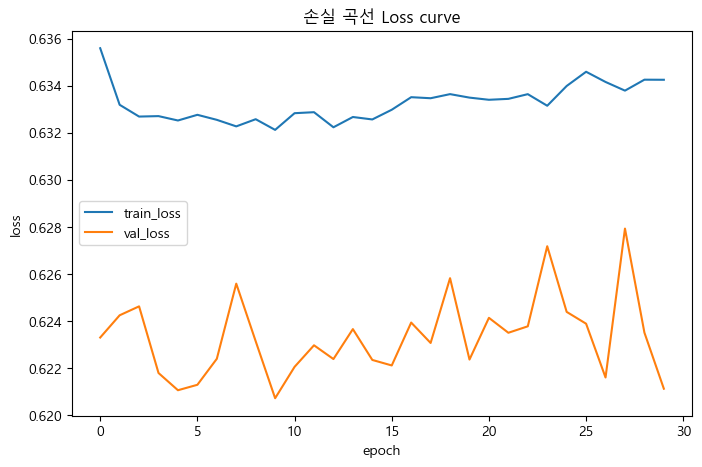

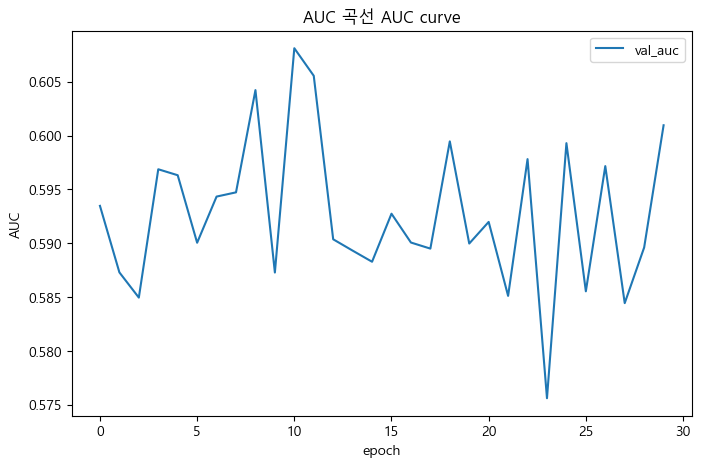

In [36]:
plt.rcParams['font.family'] = 'Malgun Gothic'     
plt.rcParams['axes.unicode_minus'] = False        

# 학습 곡선 (Train/Val Loss, Val AUC)
plt.figure(figsize=(8,5))                   
plt.plot(history['train_loss'], label='train_loss') # epoch 별 학습 손실 곡선
plt.plot(history['val_loss'], label='val_loss')     # epoch 별 검증 손실 곡선
plt.xlabel('epoch')                
plt.ylabel('loss')              
plt.title('손실 곡선 Loss curve')
plt.legend()                     
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history['val_auc'], label='val_auc')       # epoch 별 검증 AUC 값
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC 곡선 AUC curve')
plt.legend()
plt.show()

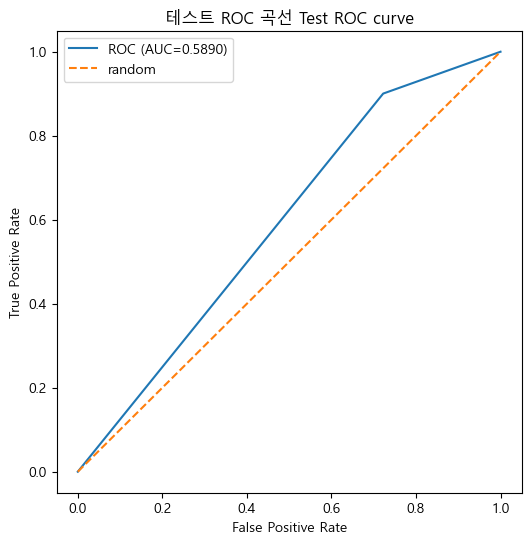

In [37]:
# ROC 곡선 (fpr: False Positive Rate, tpr: True Positive Rate, thr: Thread Hold 입계값)
fpr, tpr, thr = roc_curve(y_true, y_prob)                   # 실제값(y_true)와 예측 확률(y_prob)으로 ROC 곡선 좌표 계산

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={test_auc:.4f})')       # 모델의 ROC 곡선 및 AUC 값 표시
plt.plot([0, 1], [0, 1], linestyle='--', label='random')    # 대각선 (기준선)
plt.xlabel('False Positive Rate')                           # x축: 거짓 양성 비율
plt.ylabel('True Positive Rate')                            # y축: 참 양성 비율
plt.title('테스트 ROC 곡선 Test ROC curve')
plt.legend()
plt.show()

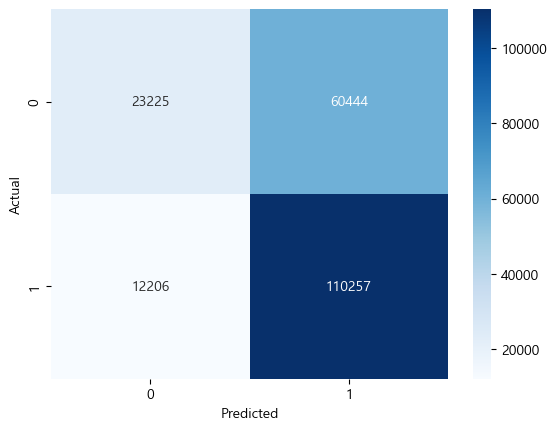

In [38]:
# # 혼동행렬 (Confusion Matrix)
y_pred = (y_prob > 0.5).astype(int)               
# cm = confusion_matrix(y_true, y_pred)              
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
# disp.plot()                                        
# plt.title('테스트 Confusion Matrix')
# plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()